In [1]:
import networkx as nx
from openai import AsyncOpenAI
import httpx
import dotenv
import os
from data_generation_utils import generate_dataset_from_graph
import matplotlib.pyplot as plt
from collections import Counter


dotenv.load_dotenv()

api_key = os.getenv("OPENAI_API_KEY") or None
client = AsyncOpenAI(
    base_url=os.getenv("OPENAI_BASE_URL"),
    api_key=api_key,
    http_client=httpx.AsyncClient(
        http2=True,
        timeout=120.0,
        limits=httpx.Limits(max_connections=1000, max_keepalive_connections=20),
    ),
)
model = os.getenv("OPENAI_COMPLETIONS_MODEL") or ""

Firstly, let us generate random social networks with some properties. We have 2 options, `nx.extended_barabasi_albert_graph` and `nx.powerlaw_cluster_graph`


In [2]:
def print_graph_properties(graph: nx.Graph):
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")
    print(f"Density: {nx.density(graph)}")
    print(
        f"Average degree: {sum(dict(graph.degree()).values()) / graph.number_of_nodes() if graph.number_of_nodes() > 0 else 0}"
    )
    print(f"Is connected: {nx.is_connected(graph)}")
    print(f"Average clustering coefficient: {nx.average_clustering(graph)}")
    print(
        f"Diameter: {nx.diameter(graph)}"
        if nx.is_connected(graph)
        else "Graph is not connected, diameter is undefined"
    )
    print(
        f"Average shortest path length: {nx.average_shortest_path_length(graph)}"
        if nx.is_connected(graph)
        else "Graph is not connected, average shortest path length is undefined"
    )

    plt.hist(
        [d for n, d in graph.degree()], bins=10, color="lightgreen", edgecolor="black"
    )
    plt.title("Degree Histogram of Graph")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

# Basic comparison


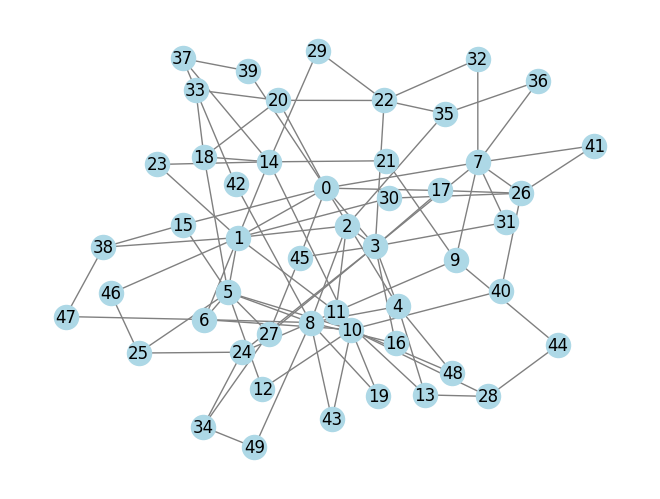

Number of nodes: 50
Number of edges: 98
Density: 0.08
Average degree: 3.92
Is connected: True
Average clustering coefficient: 0.14452958152958154
Diameter: 5
Average shortest path length: 2.7755102040816326


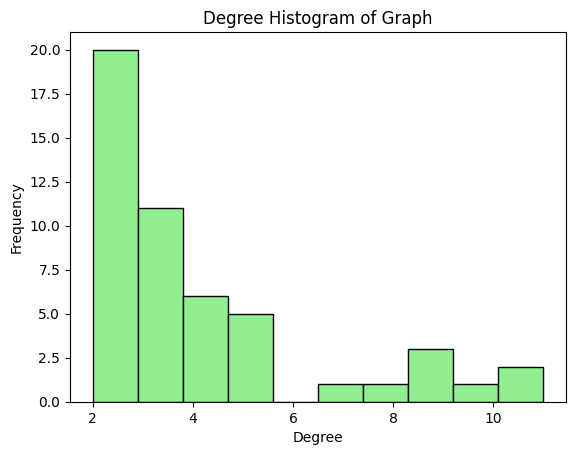

In [3]:
extended_barabasi = nx.extended_barabasi_albert_graph(50, 2, p=0.1, q=0.05, seed=42)
nx.draw_spring(
    extended_barabasi, with_labels=True, node_color="lightblue", edge_color="gray"
)
plt.show()
print_graph_properties(extended_barabasi)

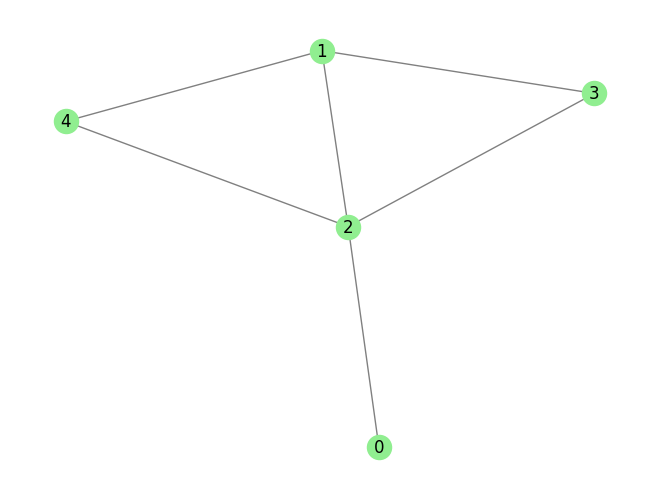

Number of nodes: 5
Number of edges: 6
Density: 0.6
Average degree: 2.4
Is connected: True
Average clustering coefficient: 0.6
Diameter: 2
Average shortest path length: 1.4


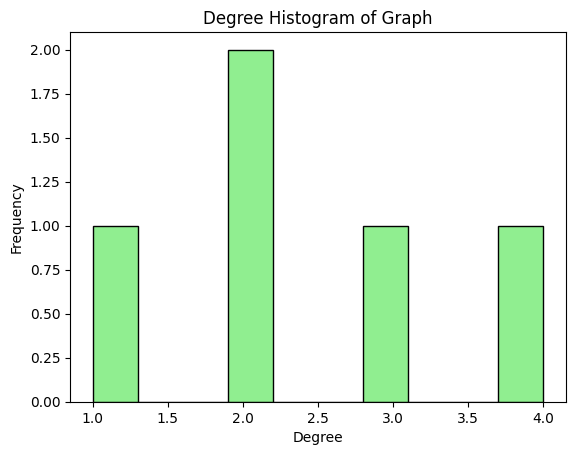

In [4]:
powerlaw = nx.powerlaw_cluster_graph(5, 2, 0.5, seed=42)
nx.draw_spring(powerlaw, with_labels=True, node_color="lightgreen", edge_color="gray")
plt.show()
print_graph_properties(powerlaw)

From the graphs, it looks like the extended barabasi provides more spread out graph, we will continue with this method.


# Barabasi-Albert


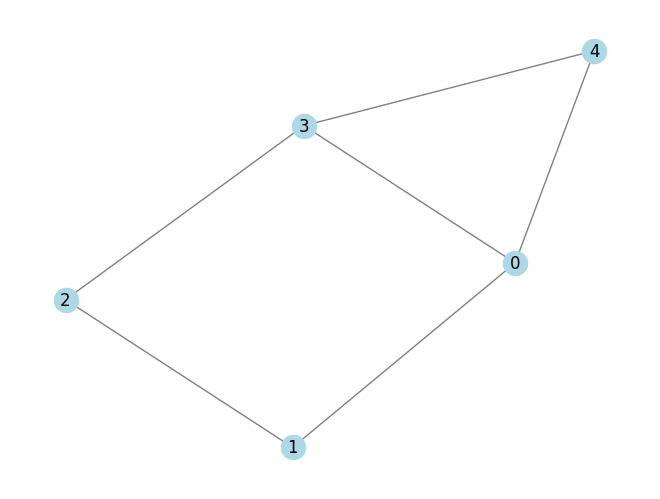

Number of nodes: 5
Number of edges: 6
Density: 0.6
Average degree: 2.4
Is connected: True
Average clustering coefficient: 0.3333333333333333
Diameter: 2
Average shortest path length: 1.4


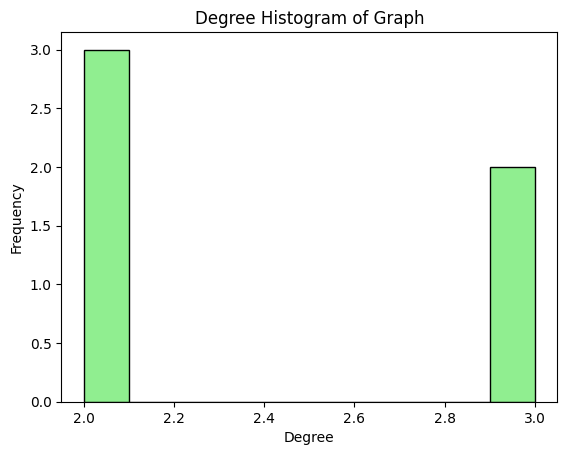

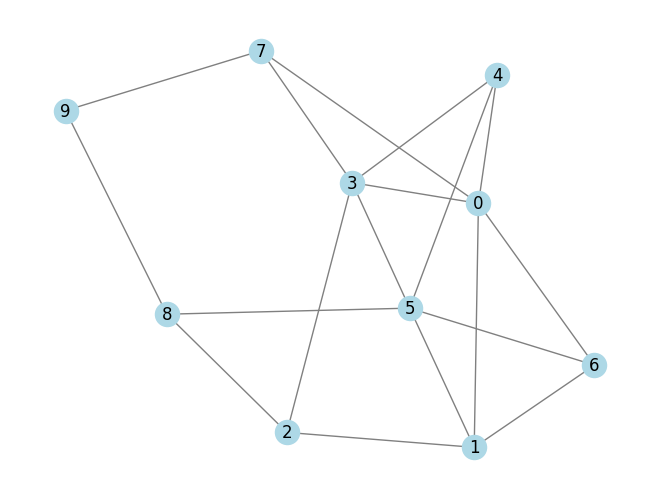

Number of nodes: 10
Number of edges: 18
Density: 0.4
Average degree: 3.6
Is connected: True
Average clustering coefficient: 0.27999999999999997
Diameter: 3
Average shortest path length: 1.6888888888888889


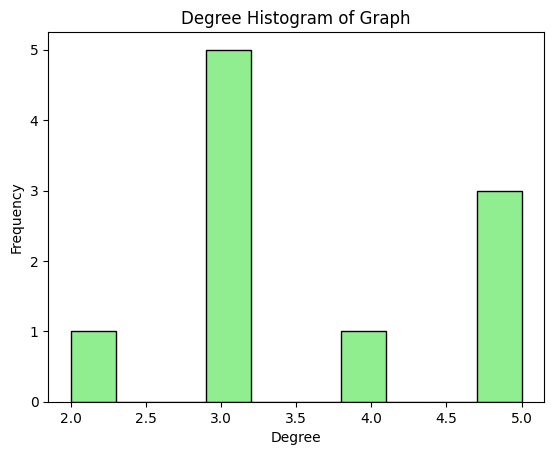

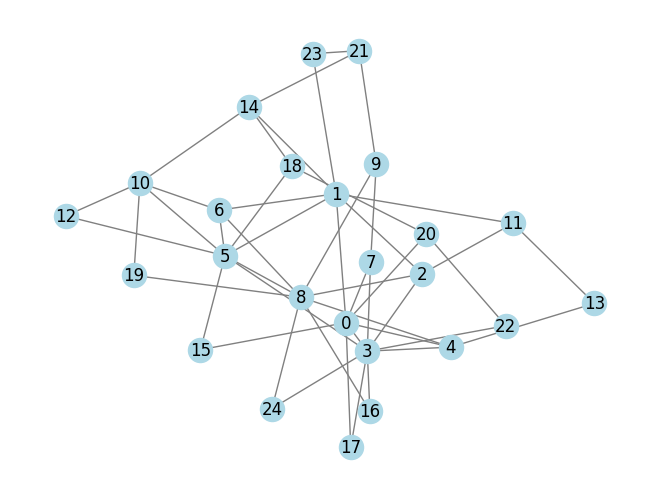

Number of nodes: 25
Number of edges: 48
Density: 0.16
Average degree: 3.84
Is connected: True
Average clustering coefficient: 0.168
Diameter: 4
Average shortest path length: 2.31


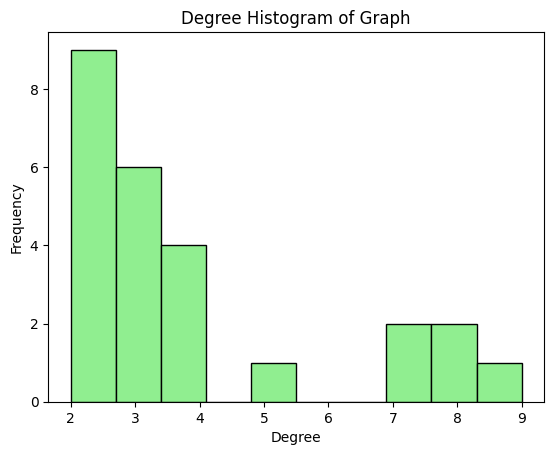

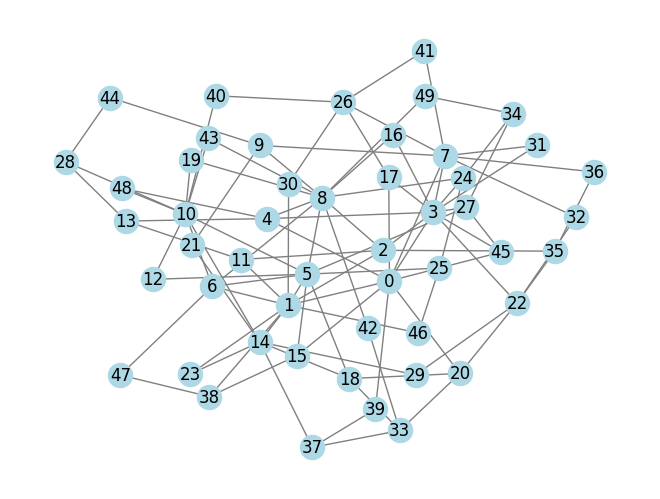

Number of nodes: 50
Number of edges: 98
Density: 0.08
Average degree: 3.92
Is connected: True
Average clustering coefficient: 0.14452958152958154
Diameter: 5
Average shortest path length: 2.7755102040816326


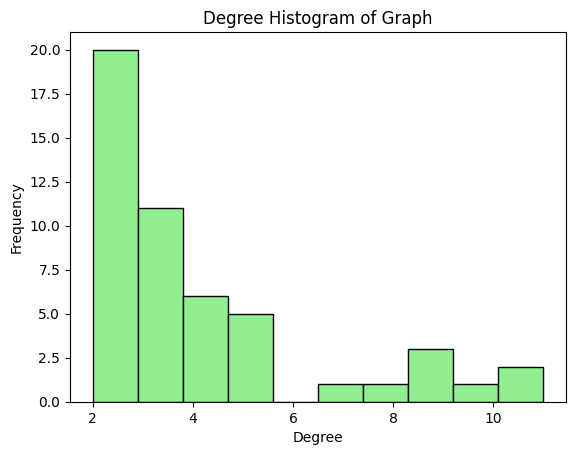

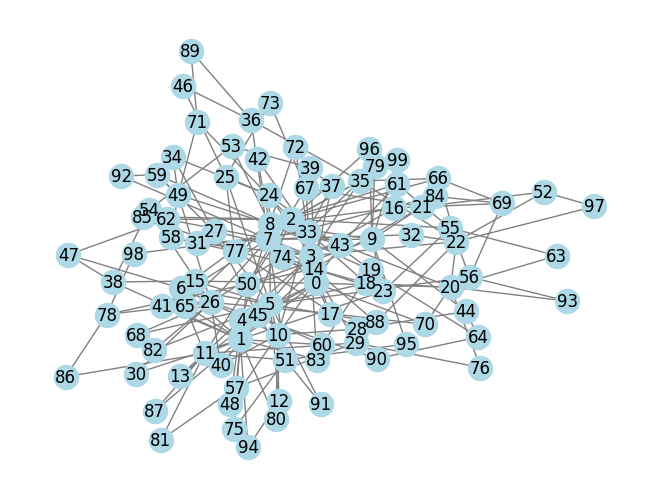

Number of nodes: 100
Number of edges: 222
Density: 0.044848484848484846
Average degree: 4.44
Is connected: True
Average clustering coefficient: 0.08935699104816752
Diameter: 6
Average shortest path length: 2.978989898989899


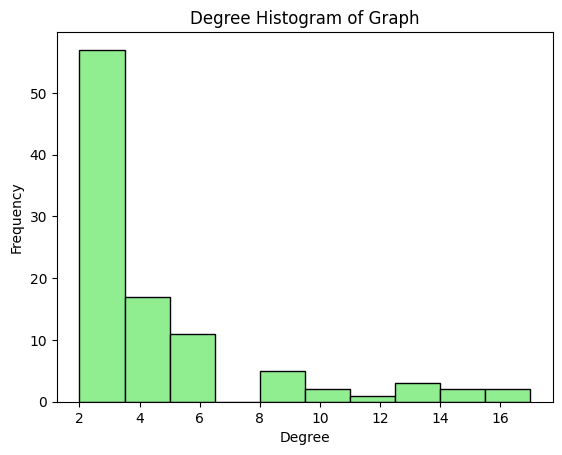

In [5]:
sizes = [5, 10, 25, 50, 100]
graphs = [
    nx.extended_barabasi_albert_graph(size, 2, p=0.1, q=0.05, seed=42) for size in sizes
]
for graph in graphs:
    nx.draw_spring(graph, with_labels=True, node_color="lightblue", edge_color="gray")
    plt.show()
    print_graph_properties(graph)

# Powerlaw


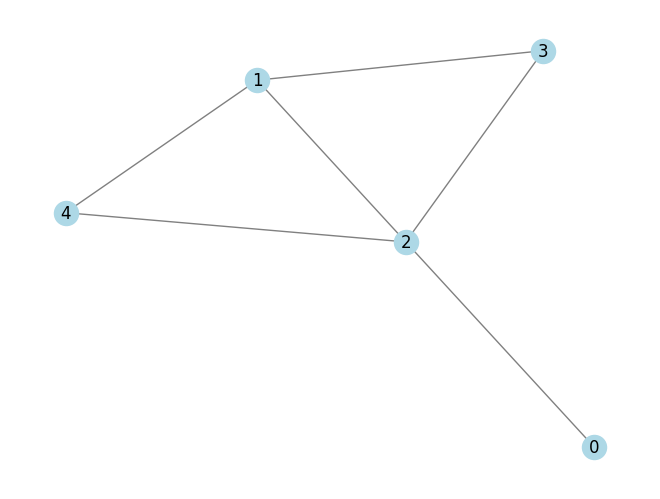

Number of nodes: 5
Number of edges: 6
Density: 0.6
Average degree: 2.4
Is connected: True
Average clustering coefficient: 0.6
Diameter: 2
Average shortest path length: 1.4


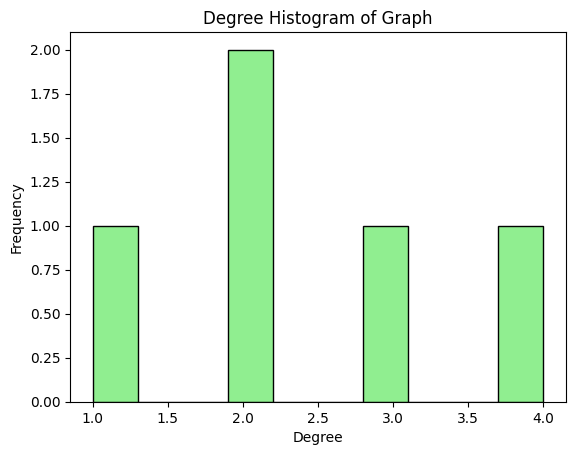

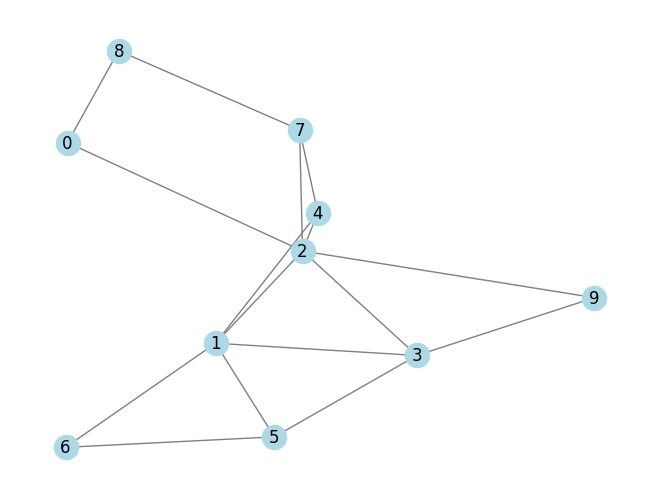

Number of nodes: 10
Number of edges: 16
Density: 0.35555555555555557
Average degree: 3.2
Is connected: True
Average clustering coefficient: 0.4833333333333333
Diameter: 4
Average shortest path length: 1.9111111111111112


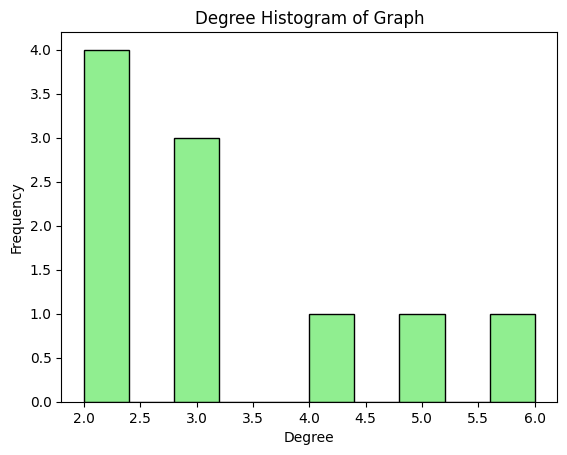

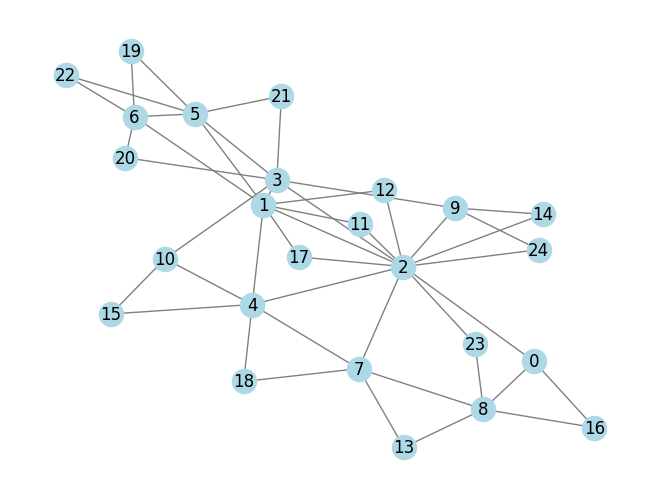

Number of nodes: 25
Number of edges: 46
Density: 0.15333333333333332
Average degree: 3.68
Is connected: True
Average clustering coefficient: 0.6057402597402597
Diameter: 5
Average shortest path length: 2.453333333333333


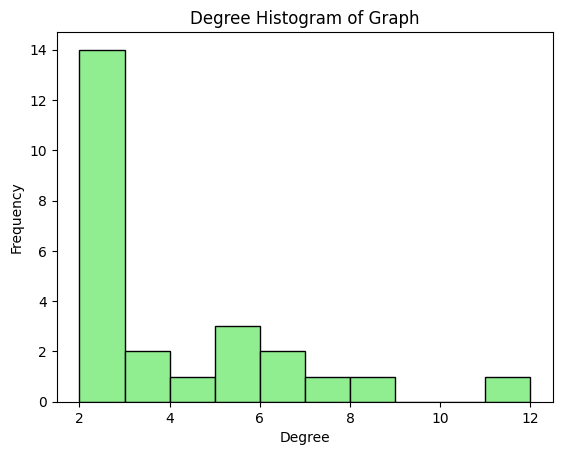

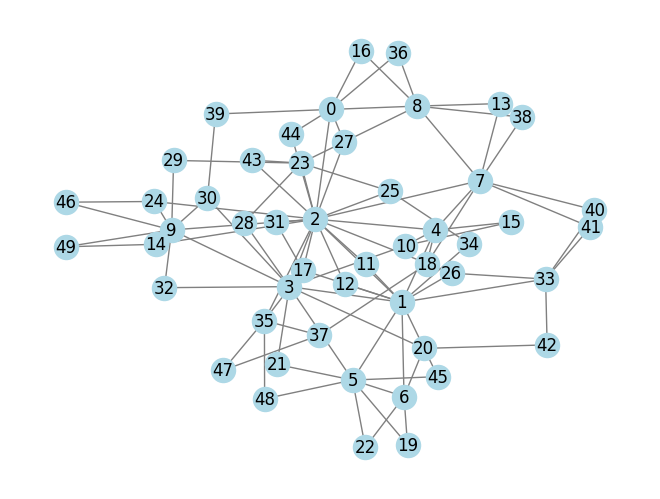

Number of nodes: 50
Number of edges: 96
Density: 0.0783673469387755
Average degree: 3.84
Is connected: True
Average clustering coefficient: 0.5095524417103364
Diameter: 5
Average shortest path length: 2.7289795918367346


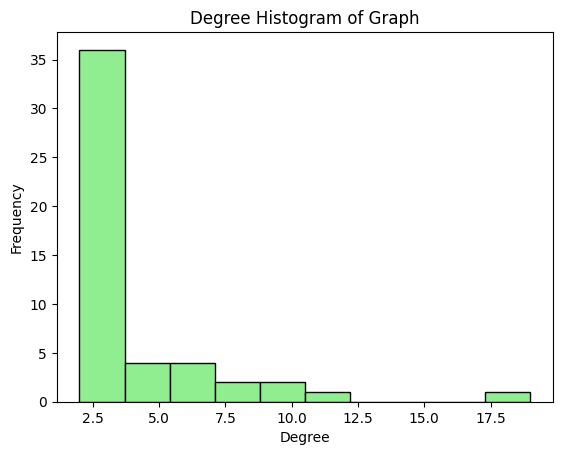

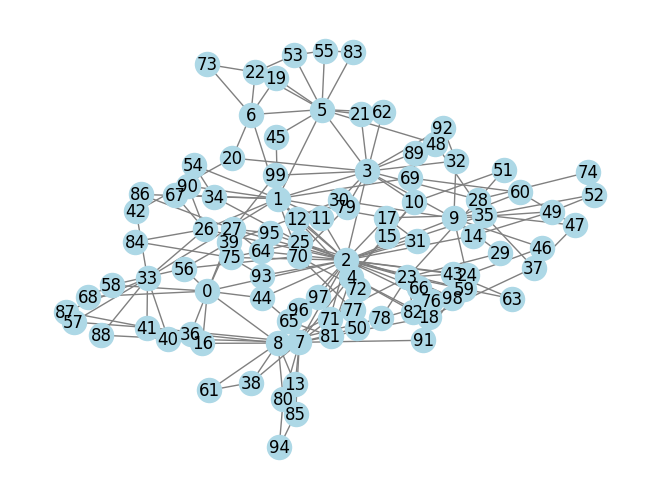

Number of nodes: 100
Number of edges: 196
Density: 0.039595959595959594
Average degree: 3.92
Is connected: True
Average clustering coefficient: 0.5298718319946972
Diameter: 6
Average shortest path length: 3.062626262626263


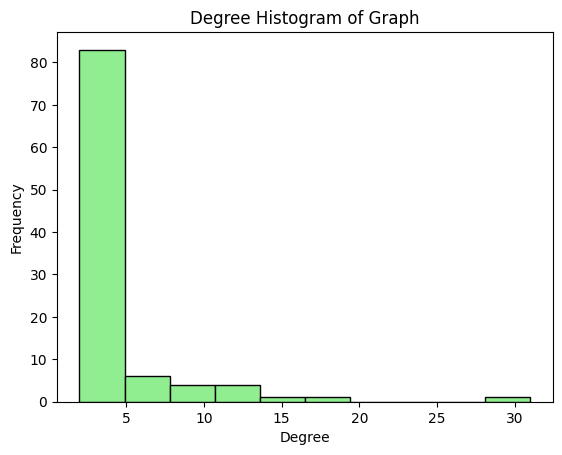

In [6]:
sizes = [5, 10, 25, 50, 100]
graphs = [nx.powerlaw_cluster_graph(size, 2, 0.5, seed=42) for size in sizes]
for graph in graphs:
    nx.draw_spring(graph, with_labels=True, node_color="lightblue", edge_color="gray")
    plt.show()
    print_graph_properties(graph)

# Comparison

Now we compare the degree distribution between the methods.


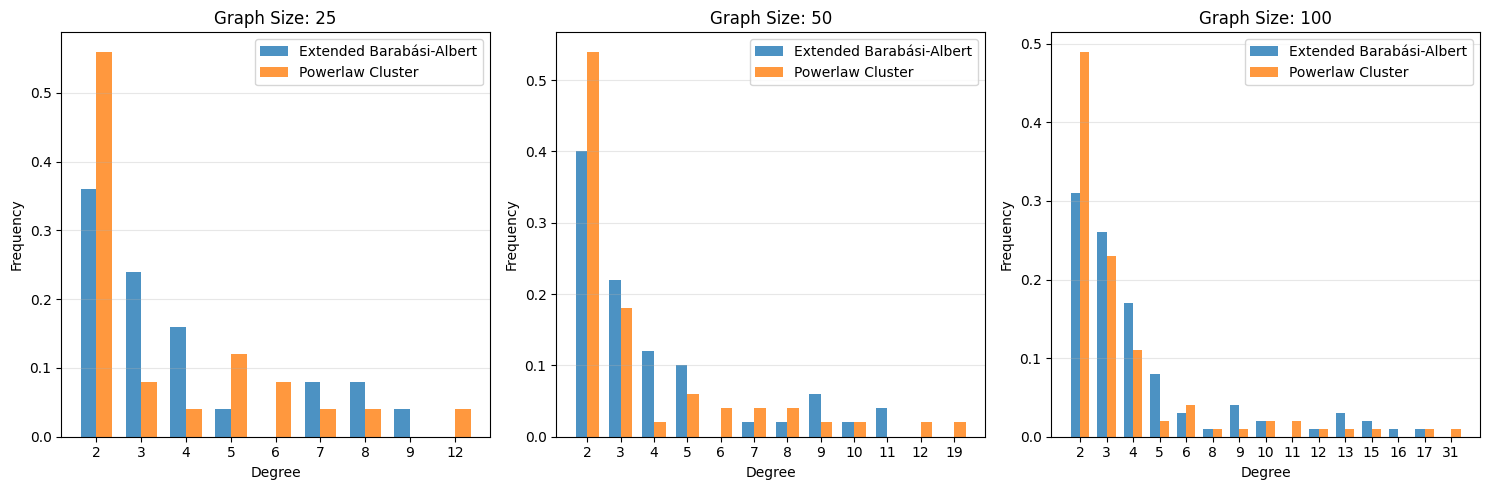

In [7]:
sizes = [25, 50, 100]
eba_graphs = [
    nx.extended_barabasi_albert_graph(size, 2, p=0.1, q=0.05, seed=42) for size in sizes
]
plc_graphs = [nx.powerlaw_cluster_graph(size, 2, 0.5, seed=42) for size in sizes]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
for idx, size in enumerate(sizes):
    ax = axes[idx]

    eba_degrees = [d for n, d in eba_graphs[idx].degree()]
    plc_degrees = [d for n, d in plc_graphs[idx].degree()]

    eba_degree_counts = Counter(eba_degrees)
    plc_degree_counts = Counter(plc_degrees)

    all_degrees = sorted(set(eba_degrees) | set(plc_degrees))

    eba_freq = [eba_degree_counts.get(d, 0) / len(eba_degrees) for d in all_degrees]
    plc_freq = [plc_degree_counts.get(d, 0) / len(plc_degrees) for d in all_degrees]

    width = 0.35
    x = list(range(len(all_degrees)))

    ax.bar(
        [i - width / 2 for i in x],
        eba_freq,
        width,
        label="Extended Barabási-Albert",
        alpha=0.8,
    )
    ax.bar(
        [i + width / 2 for i in x], plc_freq, width, label="Powerlaw Cluster", alpha=0.8
    )

    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Graph Size: {size}")
    ax.set_xticks(x)
    ax.set_xticklabels(all_degrees)
    ax.legend()
    ax.grid(axis="y", alpha=0.3)
# plt.suptitle(
#     "Degree Distribution Comparison: Extended Barabási-Albert vs Powerlaw Cluster",
#     fontsize=14,
#     y=1.02,
# )
plt.tight_layout()
os.makedirs("experiments/assets", exist_ok=True)
plt.savefig(
    "assets/degree_distribution_comparison.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In the next steps, we generate and save the datasets in different sizes. The sizes chosen for future experiments are 5, 10, 25, 50 and 100. This might be further extended to cover even bigger graphs.


## Dataset Generation Approach:

We select a main node (based on betweenness centrality), generate its persona and then extend the network. We always send the node's neighborhood (ego network) as context along with all previously generated personas (some basic info). We expand gradually like a tree from that single vertex, expanding in the direction of maximum centrality, starting from the initial max centrality node and always selecting neighbors with the highest centrality.

Then we take that one vertex and modify it, infuse some information we want to test whether (and how quickly) it will spread. We save the result.

## Graph Structure:

Going forward, we select extended_barabasi_albert_graph as the source of graph structure, since the distribution is more even and that is more interesting for information spread experiments. Also, the average shortest path is slightly lower here. It will be generated using the Mistral large model to obtain complex and diverse data.


In [ ]:
import asyncio

sizes = [
    5,
    10,
    25,
    50,
    100,
]
graphs = [
    nx.extended_barabasi_albert_graph(size, 2, p=0.1, q=0.05, seed=42) for size in sizes
]


async def generate_single_dataset(graph: nx.Graph, size: int):
    try:
        print(f"Generating dataset for graph of size {size}...")
        dataset = await generate_dataset_from_graph(
            graph, nx.betweenness_centrality(graph), client, model
        )
        print(f"Dataset for graph of size {size} generated, saving to file...")
        print(
            f"Generated in {dataset.dataset_generation_stats.time_seconds} s, {dataset.dataset_generation_stats.input_tokens}/{dataset.dataset_generation_stats.output_tokens} tokens"
        )
        print()
        with open(f"../data/synthetic_{size}.json", "w") as f:
            f.write(dataset.model_dump_json(indent=1))
    except Exception as e:
        print(f"Error generating dataset for graph of size {size}")
        print(e)


await asyncio.gather(
    *[generate_single_dataset(graph, size) for graph, size in zip(graphs, sizes)]
)

Generating dataset for graph of size 100...
1 / 100 agents generated. Using 3929 / 956 in 19.80 s.
2 / 100 agents generated. Using 4237 / 1250 in 25.82 s.
3 / 100 agents generated. Using 5600 / 1315 in 28.03 s.
4 / 100 agents generated. Using 5161 / 2030 in 49.28 s.
5 / 100 agents generated. Using 6375 / 2950 in 89.49 s.
6 / 100 agents generated. Using 10777 / 2566 in 72.40 s.
7 / 100 agents generated. Using 8615 / 3218 in 94.63 s.
8 / 100 agents generated. Using 10545 / 2335 in 68.26 s.
9 / 100 agents generated. Using 12785 / 2454 in 78.19 s.
10 / 100 agents generated. Using 9777 / 1509 in 45.35 s.
11 / 100 agents generated. Using 10216 / 2027 in 59.26 s.
12 / 100 agents generated. Using 11348 / 3327 in 218.49 s.
13 / 100 agents generated. Using 17222 / 2747 in 76.68 s.
14 / 100 agents generated. Using 14626 / 2069 in 56.34 s.
15 / 100 agents generated. Using 11973 / 1480 in 36.04 s.
16 / 100 agents generated. Using 17315 / 2435 in 71.54 s.
17 / 100 agents generated. Using 16522 / 216

[None]